In [51]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from dateutil.parser import parse
import datetime as dt

import seaborn as sns

import requests

In [3]:
# Define paths

DATA_DIR = './data/'
LIAR_DIR = DATA_DIR + 'liar/'

In [4]:
cols = ["ID", "label", "statement", "subject", "speaker", "job", "state", "party", "barely_true_cts",
        "false_cts", "half_true_cts", "mostly_true_cts", "pants_on_fire_cts", "context"]
    
df_raw = pd.read_table(LIAR_DIR + 'train.tsv', header=None)
df_raw.columns = cols
df_raw.head()

,ID,label,statement,subject,speaker,job,state,party,barely_true_cts,false_cts,half_true_cts,mostly_true_cts,pants_on_fire_cts,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [5]:
def get_statement(id):
    resp = requests.get('wget http://www.politifact.com//api/v/2/statement/%d?format\=json' % id)
    print(resp.json)

## Sentiment analysis

One approach to feature augmentation we considered is using sentiment analysis. In the following, we use the nltk library to extract the sentiment of each statement.

For each statement, we can extract 4 metrics: negativity, positivity, neutrality and a compound value of all of these metrics.

An interesting observation is that for all 6 available truth labels, all the metrics follow the same distribution, suggesting that the dataset is well balanced in this regard.

We have chosen the nltk library due to its flexibility. The above analysis is based on the *vader lexicon*, which might not generalize well to the type of statements in this datset. However, the library provides a classifier that we plan to train on this dataset and repeat this analysis.

In [110]:
import nltk
nltk.download('vader_lexicon')

def nltk_sentiment(sentence):
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    
    nltk_sentiment = SentimentIntensityAnalyzer()
    score = nltk_sentiment.polarity_scores(sentence)
    return score

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/paul/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [111]:
nltk_results = [nltk_sentiment(row) for row in df_raw.statement]
results_df = pd.DataFrame(nltk_results)
text_df = pd.DataFrame(df_raw, columns = ['ID'])
nltk_df = text_df.join(results_df)

In [112]:
nltk_df.head(5)

,ID,compound,neg,neu,pos
0,2635.json,0.2500,0.115,0.692,0.192
1,10540.json,0.3612,0.000,0.902,0.098
2,324.json,0.3182,0.107,0.687,0.206
3,1123.json,0.7579,0.000,0.606,0.394
4,9028.json,0.0000,0.000,1.000,0.000


In [113]:
data_with_sentiments = nltk_df.merge(df_raw)

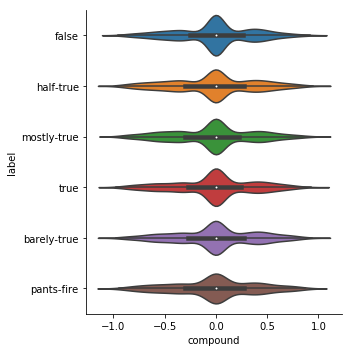

In [114]:
ax = sns.catplot(x='compound', y='label', data=data_with_sentiments, kind="violin")

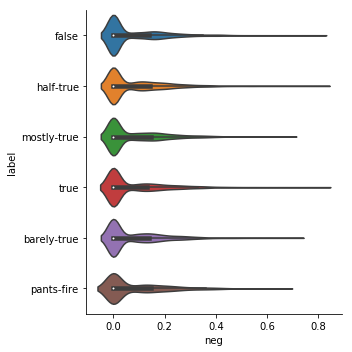

In [115]:
ax = sns.catplot(x='neg', y='label', data=data_with_sentiments, kind="violin")

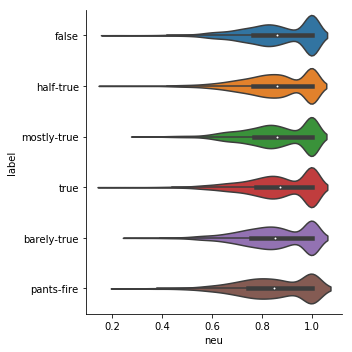

In [116]:
ax = sns.catplot(x='neu', y='label', data=data_with_sentiments, kind="violin")

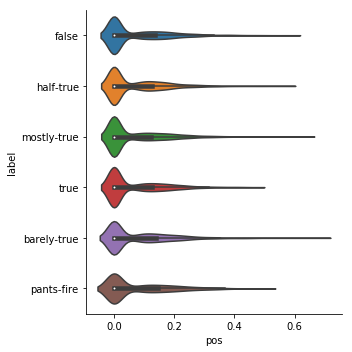

In [117]:
ax = sns.catplot(x='pos', y='label', data=data_with_sentiments, kind="violin")